In [1]:
!nvidia-smi

Sat Sep 25 23:08:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108... WDDM  | 00000000:01:00.0  On |                  N/A |
| 13%   48C    P8    23W / 260W |    652MiB / 11264MiB |      3%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [11]:
import os
import sys
from multiprocessing import Pool
from collections import OrderedDict
from time import time
import datetime
from importlib import reload

import pandas as pd
import numpy as np
import random
import torch 
from torch import nn
from torch.utils.data import dataloader
from transformers import AutoTokenizer, BertModel


import data_processing
from utils import *

device = torch.device('cuda:0')
print(device)

%matplotlib inline

cuda:0


# Pretrain Models

In [3]:
"""
path
"""
ori_tokenizer_path = '../nlp_resource/transformers/bert-base-chinese/' # tokenizer
ori_bert_path = '../nlp_resource/transformers/bert-base-chinese/' # bert

In [4]:
t_path = ori_tokenizer_path
b_path = ori_bert_path

tokenizer = AutoTokenizer.from_pretrained(t_path)
bert = BertModel.from_pretrained(b_path).to(device)
bert.training

False

In [ ]:
"""
vocab
"""
vocab = list(tokenizer.vocab.keys())
vocab_dict = dict(tokenizer.vocab) # 转换成local域的dict，速度快到飞起。。

k,v = list(zip(*list(vocab_dict.items())))
vocab_dict_reverse = {}
for i in range(len(k)):
    vocab_dict_reverse[v[i]] = k[i] # k-v 反转字典

In [16]:
tokenizer.tokenize('我数据embasf嚒是')

['我', '数', '据', 'emba', '##s', '##f', '[UNK]', '是']

# Dataset

In [12]:
data_processor = data_processing.DataProcessor()

In [7]:
tokenizer.__setattr__()

<method-wrapper '__setattr__' of BertTokenizerFast object at 0x0000016F3ACE97F0>

In [7]:
data_processor.vocab

{'a': 1234}

In [8]:
c = data_processor.vocab

In [10]:
c is data_processor.vocab

True

In [18]:
data_processor.set_vocab(tokenizer.vocab)

In [19]:
data_processor.vocab is tokenizer.vocab

False

In [20]:
id(data_processor.vocab)

1436841733288

In [22]:
id(tokenizer.vocab)

1436840792352

In [25]:
data_processor.vocab['庹'] = 1000

In [29]:
a  = tokenizer.vocab

In [30]:
a is tokenizer.vocab

False

In [26]:
data_processor.vocab

{'##凛': 14180,
 '庹': 1000,
 'fb': 8573,
 '俟': 926,
 '蛰': 6038,
 'mx': 11171,
 '誉': 6289,
 '梨': 3459,
 '､': 8084,
 '畑': 4520,
 '妤': 1979,
 '##柞': 16443,
 '##que': 9477,
 '##us': 8293,
 '##more': 11286,
 '##艘': 18732,
 '##潑': 17105,
 '##瀏': 17161,
 '抄': 2826,
 '诣': 6419,
 'run': 9909,
 '##59': 9632,
 '言': 6241,
 '205': 9860,
 '↓↓': 12558,
 '捅': 2927,
 '##壺': 14960,
 'volvo': 11048,
 '巾': 2353,
 '##強': 15542,
 '##拔': 15926,
 '##怜': 15646,
 '##械': 16519,
 '##沈': 16812,
 '煥': 4210,
 '啞': 1563,
 '统': 5320,
 '翊': 5421,
 '扭': 2814,
 '绝': 5318,
 '耒': 5448,
 '嘻': 1677,
 '##2000': 9842,
 'suite': 11420,
 '##35': 8852,
 '##✈': 13632,
 '1956': 9076,
 '##卡': 14362,
 '##増': 14925,
 '抨': 2846,
 '菟': 5832,
 '邀': 6913,
 '##歙': 16686,
 '##狈': 17371,
 '##014': 11365,
 '妈': 1968,
 'xperia': 9817,
 '系': 5143,
 '##皮': 17706,
 '顽': 7559,
 '165': 9316,
 'alexander': 11733,
 '##诚': 19468,
 '淵': 3920,
 '珍': 4397,
 '欠': 3612,
 '塑': 1848,
 '##陌': 20416,
 '➤': 508,
 '##宰': 15210,
 '怙': 2588,
 '##摧': 16096,
 '##敗': 

In [27]:
tokenizer.vocab

{'##凛': 14180,
 '庹': 2436,
 'fb': 8573,
 '俟': 926,
 '蛰': 6038,
 'mx': 11171,
 '誉': 6289,
 '梨': 3459,
 '､': 8084,
 '畑': 4520,
 '妤': 1979,
 '##柞': 16443,
 '##que': 9477,
 '##us': 8293,
 '##more': 11286,
 '##艘': 18732,
 '##潑': 17105,
 '##瀏': 17161,
 '抄': 2826,
 '诣': 6419,
 'run': 9909,
 '##59': 9632,
 '言': 6241,
 '205': 9860,
 '↓↓': 12558,
 '捅': 2927,
 '##壺': 14960,
 'volvo': 11048,
 '巾': 2353,
 '##強': 15542,
 '##拔': 15926,
 '##怜': 15646,
 '##械': 16519,
 '##沈': 16812,
 '煥': 4210,
 '啞': 1563,
 '统': 5320,
 '翊': 5421,
 '扭': 2814,
 '绝': 5318,
 '耒': 5448,
 '嘻': 1677,
 '##2000': 9842,
 'suite': 11420,
 '##35': 8852,
 '##✈': 13632,
 '1956': 9076,
 '##卡': 14362,
 '##増': 14925,
 '抨': 2846,
 '菟': 5832,
 '邀': 6913,
 '##歙': 16686,
 '##狈': 17371,
 '##014': 11365,
 '妈': 1968,
 'xperia': 9817,
 '系': 5143,
 '##皮': 17706,
 '顽': 7559,
 '165': 9316,
 'alexander': 11733,
 '##诚': 19468,
 '淵': 3920,
 '珍': 4397,
 '欠': 3612,
 '塑': 1848,
 '##陌': 20416,
 '➤': 508,
 '##宰': 15210,
 '怙': 2588,
 '##摧': 16096,
 '##敗': 

## atec

In [16]:
atec = data_processor.read_data(mode='readline',
                                name='atec', 
                                path='../a_nlp_resource/dataset/ATEC/atec_nlp_sim_train.csv', 
                                sep='\t',
                                encoder='utf-8',
                                has_index=True)

atec_add = data_processor.read_data(mode='readline',
                                name='atec', 
                                path='../a_nlp_resource/dataset/ATEC/atec_nlp_sim_train_add.csv', 
                                sep='\t',
                                encoder='utf-8',
                                has_index=True)
atec = atec + atec_add

------------------------------------------
start to read: [atec]...
finish reading: [atec]
nums: 39346
['怎么更改花呗手机号码', '我的花呗是以前的手机号码，怎么更改成现在的支付宝的号码手机号', '1']
['也开不了花呗，就这样了？完事了', '真的嘛？就是花呗付款', '0']
['花呗冻结以后还能开通吗', '我的条件可以开通花呗借款吗', '0']
['如何得知关闭借呗', '想永久关闭借呗', '0']
['花呗扫码付钱', '二维码扫描可以用花呗吗', '0']
[read_data] cost 0.07s
------------------------------------------
start to read: [atec]...
finish reading: [atec]
nums: 63131
['为何我无法申请开通花呗信用卡收款', '支付宝开通信用卡花呗收款不符合条件怎么回事', '1']
['花呗分期付款会影响使用吗', '花呗分期有什么影响吗', '0']
['为什么我花呗没有临时额度', '花呗没有临时额度怎么可以负', '0']
['能不能开花呗老兄', '花呗逾期了还能开通', '0']
['我的怎么开通花呗收钱', '这个花呗是个什么啥？我没开通 我怎么有账单', '0']
[read_data] cost 0.16s


In [17]:
# 单进程处理
atec = data_processor.preprocess_similarity_data(atec)

# 多进程处理
# atec = data_processor.multi(10 ,
#                             data_processor.preprocess_similarity_data,
#                             atec)

q1 处理完毕
q2 处理完毕


## bq_corpus

In [18]:
path = './data/bq_corpus/'
bq_corpus_train = data_processor.read_data(mode='pandas',
                                           name='bq_corpus_train', 
                                           path=path+'train.csv', 
                                           sep=',',
                                           encoder='utf-8')

bq_corpus_val = data_processor.read_data(mode='pandas',
                                         name='bq_corpus_val', 
                                         path=path+'dev.csv', 
                                         sep=',',
                                         encoder='utf-8')

bq_corpus_test = data_processor.read_data(mode='pandas',
                                          name='bq_corpus_test', 
                                          path=path+'test.csv', 
                                          sep=',',
                                          encoder='utf-8')

------------------------------------------
start to read: [bq_corpus_train]...
finish reading: [bq_corpus_train]
nums: 100000
['用微信都6年，微信没有微粒贷功能', '4。  号码来微粒贷', 0]
['微信消费算吗', '还有多少钱没还', 0]
['交易密码忘记了找回密码绑定的手机卡也掉了', '怎么最近安全老是要改密码呢好麻烦', 0]
['你好 我昨天晚上申请的没有打电话给我 今天之内一定会打吗？', '什么时候可以到账', 0]
['“微粒贷开通"', '你好，我的微粒贷怎么没有开通呢', 0]
[read_data] cost 0.20s
------------------------------------------
start to read: [bq_corpus_val]...
finish reading: [bq_corpus_val]
nums: 10000
['不要借了我是试试看能否操作的', '借款审核期间能否取消借款', 0]
['亲怎样才能在钱包里有微粒货的图标呢', '借不到', 0]
['你好，我还款银行怎么更换', '怎么更换绑定还款的卡', 1]
['我的借贷额度，怎么减少了呢？', '微粒贷额度怎么才能降低', 0]
['什么时候可以知道借款成功', '2.多笔借款', 0]
[read_data] cost 0.02s
------------------------------------------
start to read: [bq_corpus_test]...
finish reading: [bq_corpus_test]
nums: 10000
['为什么我无法看到额度', '为什么开通了却没有额度', 0]
['为啥换不了', '为两次还都提示失败呢', 0]
['借了钱，但还没有通过，可以取消吗？', '可否取消', 1]
['为什么我申请额度输入密码就一直是那个页面', '为什么要输入支付密码来验证', 0]
['今天借 明天还款可以？', '今天借明天还要手续费吗', 0]
[read_data] cost 0.02s


In [19]:
# 单进程处理
bq_corpus_train = data_processor.preprocess_similarity_data(bq_corpus_train)

# 多进程处理
# bq_corpus_train = data_processor.multi(10 ,
#                             data_processor.preprocess_similarity_data,
#                             bq_corpus_train)

q1 处理完毕
q2 处理完毕


In [20]:
# 单进程处理
bq_corpus_val = data_processor.preprocess_similarity_data(bq_corpus_val)

# 多进程处理
# bq_corpus_val = data_processor.multi(10 ,
#                             data_processor.preprocess_similarity_data,
#                             bq_corpus_val)

q1 处理完毕
q2 处理完毕


In [21]:
"""
test 数据集也可以处理, 不过只使用训练集的经验知识来处理
"""
# 单进程处理
bq_corpus_test = data_processor.preprocess_similarity_data(bq_corpus_test)

# 多进程处理
# bq_corpus_test = data_processor.multi(10 ,
#                             data_processor.preprocess_similarity_data,
#                             bq_corpus_test)

(･ิϖ･ิ)っ看不到 | 3636 | ิ
(･ิϖ･ิ)っ看不到 | 982 | ϖ
(･ิϖ･ิ)っ看不到 | 3636 | ิ
伸请微粒货我到疷要等多久帮忙查下 | 30135 | 疷
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
(･ิϖ･ิ)っ看不到 | 3636 | ิ
(･ิϖ･ิ)っ看不到 | 982 | ϖ
(･ิϖ･ิ)っ看不到 | 3636 | ิ
如何还歀 | 27456 | 歀
伸请微粒货我到疷要等多久帮忙查下 | 30135 | 疷
如何还歀 | 27456 | 歀
q1 处理完毕
如何还歀 | 27456 | 歀
强烈要求增额﹉ | 65097 | ﹉
强烈要求增额﹉ | 65097 | ﹉
为什么我没有微鞡货 我借不了款 | 38817 | 鞡
如何还歀 | 27456 | 歀
如何还歀 | 27456 | 歀
2⃣️十几分钟了都没有消息！还说三分钟搞定？？？ | 8419 | ⃣
强烈要求增额﹉ | 65097 | ﹉
q2 处理完毕


## build dataset

### mlm dataset

In [22]:
"""
ori text data
"""
mlm_data = (list(zip(*bq_corpus_train))[0] 
            + list(zip(*bq_corpus_train))[1]
            + list(zip(*bq_corpus_val))[0]
            + list(zip(*bq_corpus_val))[1]
            + list(zip(*atec))[0]
            + list(zip(*atec))[1])
len(mlm_data)

424954

In [23]:
"""
drop duplicate
"""
mlm_data = list(set(mlm_data))
print(len(mlm_data))
for i in range(5):
    print(mlm_data[i])

227826
我以实名认证以绑定手机号为什么用不了花呗
商家开通花呗收款，人家怎么付款
花呗逾期芝麻分
钱在余额宝会自动还花呗
借呗还款日还款


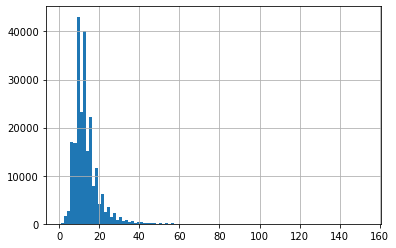

In [24]:
pd.Series(mlm_data).apply(lambda x : len(x)).hist(bins=100)

In [25]:
"""
split data idx
"""
val_idx = random.sample(range(len(mlm_data)), int(1e4))
val_hash_idx = {}
for i in val_idx:
    val_hash_idx[i]=0

In [26]:
"""
get split data
"""
val = [mlm_data[i] for i in range(len(mlm_data)) if i in val_hash_idx]
train = [mlm_data[i] for i in range(len(mlm_data)) if i not in val_hash_idx]
print(len(mlm_data),len(val), len(train))

227826 10000 217826


In [27]:
"""
mask data
"""
# 单进程
train = data_processor.get_masked_data(train) + data_processor.get_masked_data(train) # mask 两次

val = data_processor.get_masked_data(val)

# # 多进程
# res = data_processor.multi(10,
#                            data_processor.get_masked_data,
#                            mlm_data)

Inputs & labels:
['商家开[MASK]花呗收款，人家[MASK]么付款', '[PAD][PAD][PAD]通[PAD][PAD][PAD][PAD][PAD][PAD][PAD]怎[PAD][PAD][PAD]']
['花呗逾期[MASK][MASK]分', '[PAD][PAD][PAD][PAD]芝麻[PAD]']
['钱在余额宝会自动还花呗', '[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]']
['我线[MASK]支付的[MASK]呗', '[PAD][PAD]下[PAD][PAD][PAD]花[PAD]']
['[MASK]enm怎么获得资格', 'z[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]']
Inputs & labels:
['商家[MASK]通花呗收[MASK]花人家怎[MASK]付[MASK]', '[PAD][PAD]开[PAD][PAD][PAD][PAD]款，[PAD][PAD][PAD]么[PAD]款']
['花呗逾期[MASK]麻分', '[PAD][PAD][PAD][PAD]芝[PAD][PAD]']
['钱在余额[MASK]会[MASK]动还花呗', '[PAD][PAD][PAD][PAD]宝[PAD]自[PAD][PAD][PAD][PAD]']
['我线下支付的花呗', '[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]']
['z获nm怎么获得格[MASK]', '[PAD]e[PAD][PAD][PAD][PAD][PAD][PAD]资格']
Inputs & labels:
['我以实名认证以绑定手机号为什么用不了花呗', '[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]机[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]']
['借呗还[MASK]日还款', '[PAD][PAD][PAD]款[PAD][PAD][PAD]']
['花呗分期后提前还款收[MASK]续费么', '[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][P

In [28]:
train[:5]

[['商家开[MASK]花呗收款，人家[MASK]么付款',
  '[PAD][PAD][PAD]通[PAD][PAD][PAD][PAD][PAD][PAD][PAD]怎[PAD][PAD][PAD]'],
 ['花呗逾期[MASK][MASK]分', '[PAD][PAD][PAD][PAD]芝麻[PAD]'],
 ['钱在余额宝会自动还花呗', '[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]'],
 ['我线[MASK]支付的[MASK]呗', '[PAD][PAD]下[PAD][PAD][PAD]花[PAD]'],
 ['[MASK]enm怎么获得资格', 'z[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]']]

In [29]:
len(train), len(val)

(435652, 10000)

In [30]:
tokenizer(['[MASK]呗[MASK]期后能一次还清还要手术费[MASK]'], 
           padding='longest', 
           truncation=True, 
           max_length=60,
           return_tensors = 'pt')

{'input_ids': tensor([[ 101,  103, 1446,  103, 3309, 1400, 5543,  671, 3613, 6820, 3926, 6820,
         6206, 2797, 3318, 6589,  103,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [31]:
tokenizer(['花[PAD]分[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]吗'], 
           padding='longest', 
           truncation=True, 
           max_length=60,
           return_tensors = 'pt')

{'input_ids': tensor([[ 101, 5709,    0, 1146,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0, 1408,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

## dataloader

In [32]:
batch_size = 32

In [33]:
train_loader = data_processor.create_dataloader(train, 
                                                batch_size=batch_size, 
                                                is_shuffle=True)

val_loader = data_processor.create_dataloader(val, 
                                              batch_size=batch_size, 
                                              is_shuffle=False)

# test_loader = data_processor.create_dataloader(test, 
#                                                batch_size=batch_size, 
#                                                is_shuffle=False)

In [34]:
for i in train_loader:
    for j in i:
        print(j)
    break

('10000元一天利息多[MASK]钱', '你怎么把网商[MASK]关关', '我什的时候用的这个什么花呗', '花吗[MASK]以[MASK]刻[MASK]款吗', '买家的花[MASK]消费每月可以自动扣款吗', '开启[MASK]呗要支付密码吗', '[MASK]宝上为啥不显示花呗', '没绑定银，卡[MASK]花呗不还钱会[MASK]样样', '如何绑定银行卡还款蚂蜂借呗', '我第一次可以借，并且按时还款，为什么现[MASK]还[MASK][MASK]度，[MASK]提示不能借款', '蚂蚁借呗怎么调整不么额[MASK]了', '借吧怎么提高额度', '之前是有借呗的但是我关[MASK]现在怎样开通', '我已经满足[MASK]件了[MASK]是为什[MASK]还[MASK]没[MASK]借呗', '我的花吧的么不能用了', '花呗分期提前还清还会收利息么', '[MASK]呗已经[MASK]完[MASK]了退的款还退花[MASK]怎么办', '设置都对了还是不显示花呗', '怎么开通借借呗', '[MASK]呗红包找不到了，没用过', '我的花呗不是已经还[MASK]了[MASK]怎么还提示逾期[MASK]还款', '提前[MASK]款，银[MASK]卡已扣款，[MASK][MASK][MASK]示示没还', '为什么要冻结我的借呗', '借呗日期可以修改吗', '花呗不绑[MASK]银行卡', '花呗分期*[MASK]*个月还能继续分期吗', '怎么[MASK][MASK]花呗消费需要密码', '绑定[MASK]个花呗[MASK]么更换账号', '为什么我还完了花呗[MASK]有显示[MASK]还', '蚂蚁借呗的钱系统[MASK]动操作', '[MASK]呗开通了[MASK]没用会扣费吗', '蚂蚁借呗[MASK]有使用额度，怎么样才有使用额[MASK]')
('[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]少[PAD]', '[PAD][PAD][PAD][PAD][PAD][PAD]贷[PAD]闭', '[PAD][PAD]么[PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD][PAD]', '[PAD]呗可[PAD]立[PAD]还[PAD]

# mlm_model

In [35]:
model_config = {
    'max_len':60,
    'hidden_size':768,
    'embedding_size': 21128
}

In [36]:
class MlmBert(nn.Module):
    def __init__(self):
        global bert, tokenizer, model_config
       
        super().__init__()
        self.model_config = model_config
        self.bert = bert
        self.tokenizer = tokenizer
        
        self.final_part = nn.Sequential(OrderedDict([
            ('final_Linear', 
             nn.Linear(self.model_config['hidden_size'],self.model_config['hidden_size'], bias=True)),
            ('final_layernorm', 
             nn.LayerNorm(self.model_config['hidden_size'],eps=1e-12)),
            ('final_embedding', 
             nn.Linear(self.model_config['hidden_size'], self.model_config['embedding_size'], bias=False))  
        ]))
        
        # 因为emb的w本身就是v*d的, 这里不需要转置
        embedding_p = [p for p in bert.embeddings.word_embeddings.parameters()][0] 
        self.final_part.final_embedding.weight.data=embedding_p
        
    
    def through_bert(self, x):
        """
        输出hidden, shape=[batch_size, max_len, hidden_size]
        """
        token = self.tokenizer(text=x,
                               padding='longest', 
                               truncation=True, 
                               max_length=self.model_config['max_len'],
                               return_tensors = 'pt'
                               ).to(device)
        
        x = self.bert(**token)[0]
        return x
    
    
    
    def forward(self,x):
        x = self.through_bert(x)
        y_pre = self.final_part(x) 
        
        return y_pre 
    
    def save(self, path='./sbert.model'):
        torch.save(self.state_dict(), path)
        
    def load(self, path='./sbert.model'):
        self.load_state_dict(torch.load(path)) 

In [37]:
mlm_bert = MlmBert().to(device)
mlm_bert.save('init_mlm_bert.model')

In [40]:
y = mlm_bert(['我[MASK]谁', '路边有只小[MASK]鸭'])
y.shape

torch.Size([2, 9, 21128])

In [41]:
torch.softmax(y, dim=-1)

tensor([[[8.1841e-06, 1.2100e-05, 1.1672e-05,  ..., 2.9789e-06,
          5.7947e-06, 1.3584e-04],
         [7.4625e-06, 8.0546e-06, 7.7119e-06,  ..., 4.1725e-06,
          3.1306e-05, 1.4986e-04],
         [1.7083e-05, 1.5964e-05, 2.0049e-05,  ..., 3.0824e-05,
          4.0161e-06, 1.2135e-04],
         ...,
         [1.2971e-05, 1.2574e-05, 1.4126e-05,  ..., 3.6567e-05,
          5.2489e-06, 2.0516e-04],
         [1.0469e-05, 1.0181e-05, 1.1772e-05,  ..., 2.4986e-05,
          7.4674e-06, 2.4631e-04],
         [1.1310e-05, 1.0577e-05, 1.2863e-05,  ..., 1.9646e-05,
          6.3331e-06, 2.0643e-04]],

        [[1.0099e-05, 1.2129e-05, 1.5939e-05,  ..., 3.1933e-06,
          1.4020e-05, 9.1333e-05],
         [5.5154e-06, 6.5497e-06, 5.4712e-06,  ..., 2.4468e-06,
          3.3849e-05, 2.1143e-04],
         [1.8058e-05, 2.2656e-05, 1.6372e-05,  ..., 2.5847e-05,
          1.1958e-05, 9.0633e-05],
         ...,
         [1.0650e-05, 9.6695e-06, 1.1568e-05,  ..., 7.4842e-06,
          3.358

In [2]:
y_tid = y.argmax(dim=-1).tolist()
for idx, s in enumerate(y_tid):
    print(f'str{idx}: ',end='')
    print(''.join(tokenizer.convert_ids_to_tokens(s)))

NameError: name 'y' is not defined

# trainer

In [ ]:
class TrainProcessor():
    def __init__(self, model, train_loader, val_loader):
        self.model = model
        
        self.train = train_loader
        self.val = val_loader
        
        self._set_loss_optimizer()  
        
        self.best_val_loss = 10000  # model评测
        self.best_val_acc = 0 # model评测2
        
        self.current_step = -1
        
        self.training_time = None # 训练时间日期，每次训练时覆盖
        
        
    def _set_loss_optimizer(self):
        self.loss = nn.CrossEntropyLoss(reduction='none') # 注意得到的loss还要去mask，所以不能提前mean
        print(f'loss initialled: {self.loss}')
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5)
#         self.optimizer = torch.optim.SGD(self.model.parameters(), lr=2e-5)
        print(f'optimizer initialled: {self.optimizer}')
    
    def _print_time_now(self):
        now = datetime.datetime.today()
        print(now)
    
    def _train_one_epoch(self):
        self.model.train()  # 开启训练模式
        assert self.model.training
        
        for batch in self.train:
            self.current_step += 1
            
            x, y = (list(i) for i in batch)
            y_pre = self.model(x).transpose(1,2) # transpose 是为了匹配后面的loss
            y = self.model.get_token(y)['input_ids']
            y_mask = self.model.get_y_mask(y)
            
            self.optimizer.zero_grad()
            l = self.loss(y_pre, y)
            # mask 掉不需要预测的
            l = torch.sum( (l*y_mask)/torch.unsqueeze(y_mask.sum(dim=-1), dim=1) )
            l.backward()
            self.optimizer.step()
            
            
            self._post_processing_per_step()
        
        
    def evaluate(self,data_loader, name):
        self.model.eval()  # 开启测试模式
        assert not self.model.training
        self._print_time_now()
         
        loss = 0
        acc_num = 0
        with torch.no_grad():
            for batch in data_loader:
                x, y = (list(i) for i in batch)
                y_pre = self.model(x).transpose(1,2) # transpose 是为了匹配后面的loss
                y = self.model.get_token(y)['input_ids']
                y_mask = self.model.get_y_mask(y)
                
                l = self.loss(y_pre, y)
                # mask 掉不需要预测的
                l = (l*y_mask)/torch.unsqueeze(y_mask.sum(dim=-1), dim=1)
                loss += l
                acc_num += torch.sum(y_hat.argmax(dim=1)==y)
            
            acc = acc_num/(len(data_loader)*data_loader.batch_size)
            loss = loss/len(data_loader)
            print(f'{name:6s} | loss:{loss:0.4f} | acc:{acc:0.4f}')
            
            return loss, acc
    
              
    def trainng(self, epoch=10):
        print('start training: ')
        self.training_time = datetime.datetime.today()
        print(self.training_time)
        
        self.total_epoch = epoch
        torch.set_grad_enabled(True)
        assert torch.is_grad_enabled()
        
        t0 = time()
        for e in range(1, epoch+1):
            print('-'*42)
            self.current_epoch = e
            print(f'Epoch: {self.current_epoch}')
            
            t1 = time()
            self._train_one_epoch()
            t2 = time()
            print(f'cost:{(t2-t1)/3600:0.2f}h')
            
            self.evaluate(self.train, 'train')
            current_val_loss, current_val_acc = self.evaluate(self.val, 'val')
            
            if self.best_val_loss > current_val_loss:
                self.best_val_loss = current_val_loss
                torch.save(self.model.state_dict(), './best_val_loss_model')
                print('saved best val loss model')
                
            if self.best_val_acc < current_val_acc:
                self.best_val_acc = current_val_acc
                torch.save(self.model.state_dict(), './best_val_acc_model')
                print('saved best val acc model')
            
            self._post_processing_per_epoch()
                
        t3 = time()
        print(f'total cost: {(t3-t0)/3600:0.2f}h')
        
    def _post_processing_per_epoch(self):
        pass
    
    def _post_processing_per_step(self):
        pass

In [4]:
l = nn.CrossEntropyLoss()

In [6]:
a = torch.rand([2,20,2111])
b = torch.randint(0, 2111, [2,20])

In [18]:
b.type_as(torch.tensor(2))

tensor([[ 283,  211, 1309, 1972, 1966,   29, 1368,  473, 1068, 1610, 1060, 1540,
          174, 1570,   36,  495, 1106,  946,  723, 1531],
        [ 684, 1685, 1124, 1362,  462, 1516,  120, 1922, 1173,  377, 1518, 1448,
         1101, 1143,   55,  723,  961, 1013,  365,  403]])

In [19]:
l(b, a)

RuntimeError: "log_softmax_lastdim_kernel_impl" not implemented for 'Long'